<a href="https://colab.research.google.com/github/guipborges/Case2/blob/main/TSCNet_case2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Case

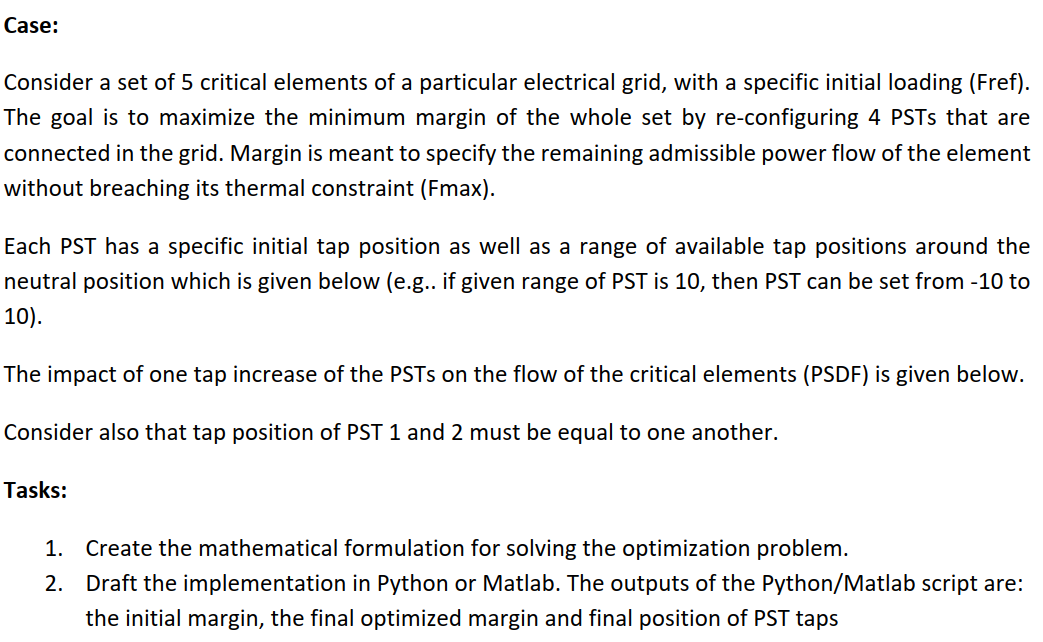

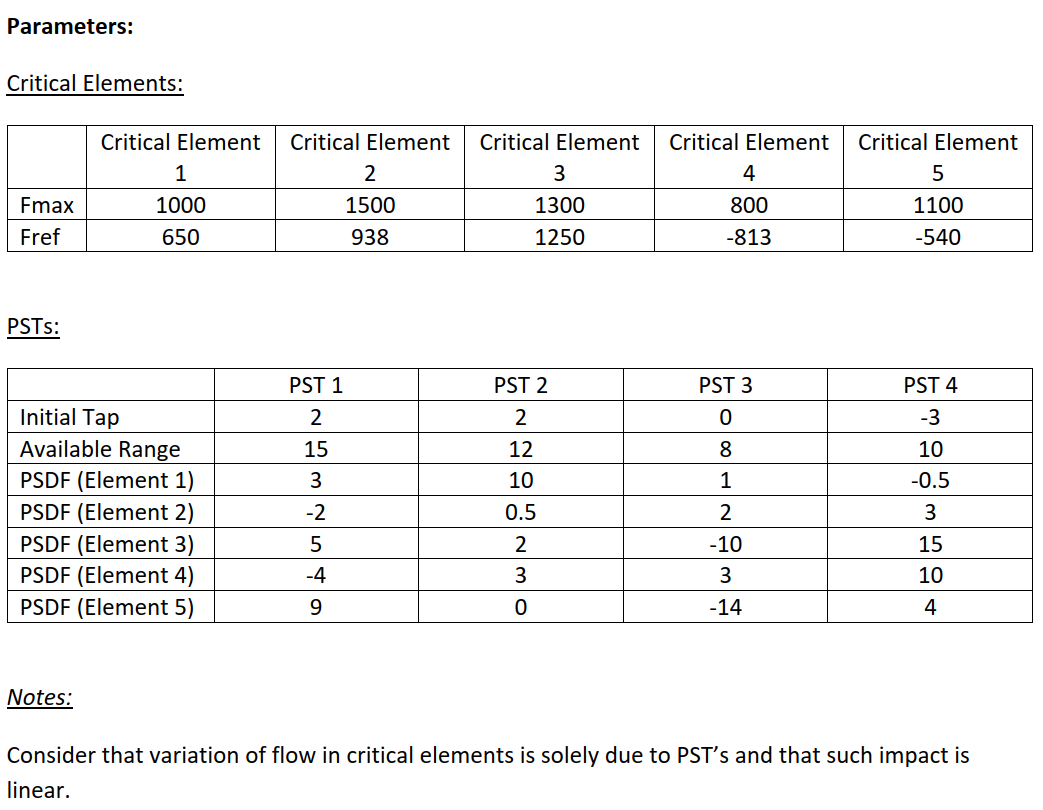

#Initial thoughts

Critical Elements:

* $F_{max}$: Refers to the maximum admissible power flow for each critical element (in arbitrary units).

* $F_{ref}$: This is the initial or reference power flow currently flowing through each critical element.

* $PSTs$:
  * Initial Tap: The initial tap position for each PST - Phase Shifter Trafo.
  * Available Range: The range of adjustment available for the tap position of each PST.

* $PSDF$ (Power System Distribution Factor): The factor that indicates how an adjustment unit in the tap position of a PST affects the power flow in each critical element.

###Interpretation of the problem. Simple example.

Let's take PST1 and Critical Element - 1 as an example:

- $PST1$:

  * Initial Tap: $2$
  * Available Range: $15$
  * PSDF (Element 1): $3$

This means that PST1 is currently in position $2$ and can be adjusted up/down to $15$ positions.

With each change of one unit in the tap position, the power flow in Critical Element 1 changes by $3$ units.

If $PST1$ is set to the maximum position = $15$ so $$(15-2 = 13) \space positions$$

the flow in Critical Element 1 would increase by $ 13 \times 3 = 39.$

$$ 13 \times 3 = 39 \space unidades $$

- Critical Element 1:

  * $F_{max}$: $1000$
  * $F_{ref}$: $650$

In addition, there is a maximum capacity that must be respected:

Critical Element 1 has an initial power flow of $650$ and can handle a maximum of $1000$. This gives an initial margin of:

$$ 1000 - 650 = 350 $$

$350$ units before the power flow exceeds the maximum capacity.

But that's just the impact of PST1. We mustn't forget that the other equipment, PST2, PST3, PST4, will also impact!


#How it's formulated


Maximize the minimum margin between the maximum admissible flow and the initial flow adjusted by the influence of the PSTs:

### Variables and Parameters:

- **Maximum permitted power flow of the critical element \( i \):**
  $$ F_{\text{max},i} $$

- **Initial power flow of the critical element \( i \):**
  $$ F_{\text{ref},i} $$

- **PST tap position $( j )$:**
  $$ T_j $$

- **Impact of an increase in the $PST_j$ in the flow of the critical element $( i )$:**
  $$ \text{PSDF}_{ij} $$

### Objective Function:

Maximize the minimum margin between the maximum admissible flow and the initial flow adjusted by the influence of the PSTs:

$$ \max \min_{i} \left( F_{\text{max},i} - \left( F_{\text{ref},i} + \sum_{j} \text{PSDF}_{ij} \cdot T_j \right) \right) $$

### Constraints:

1. **Tap position Constraints:**
   
   For each $PST_j$, the tap position $T_j$ must be within a specific range:

   $$ T_{\text{min},j} \leq T_j \leq T_{\text{max},j} \quad \forall j $$

2. **Tap Position Constraint: Same tap  for PST 1 and 2:**
   $$ T_1 = T_2 $$


### Note:

- This formulation assumes that the impact of PSTs on critical elements is linear, as mentioned in the document.
- The variables $ ( T_j ) $ and the parameters $ ( \text{PSDF}_{ij} ) $, $ ( F_{\text{max},i} ) $ and $ ( F_{\text{ref},i} ) $ must be specified on the basis of system data.




---

### The objective function calculates the minimum margin between $F_{max}$ and $F_{ref}$ adjusted for the influence of $PSTs$. Our goal is to maximize it


---


#Chart code - hypothetical graph to understand

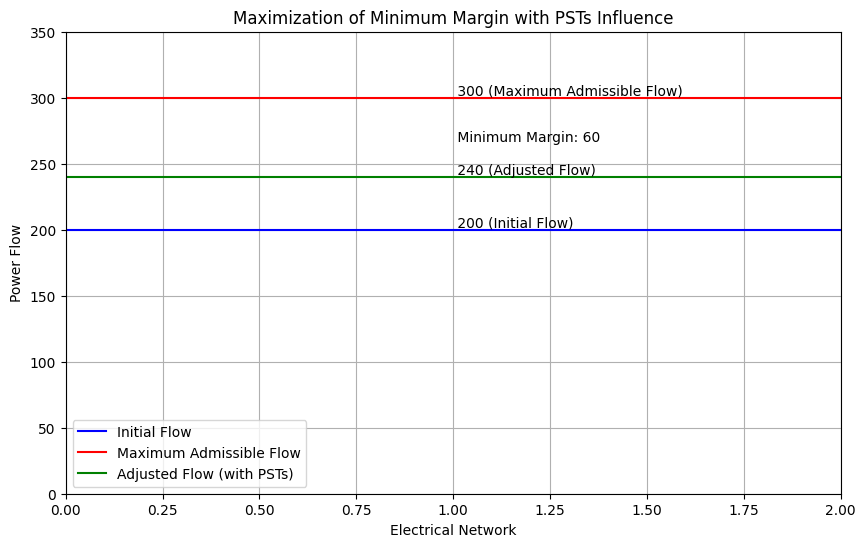

In [ ]:
#This is just a hypothetical graph to understand what needs to be done
import matplotlib.pyplot as plt

# Defining the values for the graph
inicial_flow = 200
max_admissible_flow = 300
influence_PSTs = 40  # Assuming an increase of 40 units due to PSTs
adjusted_flow = inicial_flow + influence_PSTs
minimum_margin = max_admissible_flow - adjusted_flow

# Creating the chart
plt.figure(figsize=(10, 6))

# Horizontal lines for each value
plt.axhline(y=inicial_flow, color='blue', linestyle='-', label='Initial Flow')
plt.axhline(y=max_admissible_flow, color='red', linestyle='-', label='Maximum Admissible Flow')
plt.axhline(y=adjusted_flow, color='green', linestyle='-', label='Adjusted Flow (with PSTs)')

# Explanatory texts
plt.text(1, inicial_flow, f' {inicial_flow} (Initial Flow)', verticalalignment='bottom')
plt.text(1, max_admissible_flow, f' {max_admissible_flow} (Maximum Admissible Flow)', verticalalignment='bottom')
plt.text(1, adjusted_flow, f' {adjusted_flow} (Adjusted Flow)', verticalalignment='bottom')
plt.text(1, (adjusted_flow + minimum_margin/2), f' Minimum Margin: {minimum_margin}', verticalalignment='center')

# Additional settings
plt.ylim(0, 350)
plt.xlim(0, 2)
plt.legend()
plt.title('Maximization of Minimum Margin with PSTs Influence')
plt.xlabel('Electrical Network')
plt.ylabel('Power Flow')
plt.grid(True)

# Plot the chart
plt.show()


Initial Flow (blue line): Represents the initial power flow in the network.
Maximum Admissible Flow (red line): The upper limit of power flow that the network can handle safely.
Adjusted Flow (green line): The initial flow after being adjusted by the influence of PSTs.

The **"Minimum Margin**" is the difference between the maximum admissible flow and the adjusted flow.

**The goal is to maximize this margin while keeping the adjusted flow as close as possible to the maximum admissible flow without exceeding it, ensuring safe and efficient network operation**



---



# Code



---



In [ ]:
from scipy.optimize import minimize
import numpy as np


#-------------------------------------------------------------------------------
# Initial data
#-------------------------------------------------------------------------------

# Critical Elements Data
Fmax = np.array([1000, 1500, 1300, 800, 1100])
Fref = np.array([650, 938, 1250, -813, -540])

# # PST and PSDF data
initial_taps = np.array([2, 2, 0, -3])
tap_ranges = np.array([15, 12, 8, 10])  # Maximum tap range
PSDF = np.array([
    [3, 10, 1, -0.5],    # Element 1
    [-2, 0.5, 2, 3],     # Element 2
    [5, 2, -10, 15],     # Element 3
    [-4, 3, 3, 10],      # Element 4
    [9, 0, -14, 4]       # Element 5
])

#-------------------------------------------------------------------------------
# Function for calculating the margins of critical elements
#
# The np.dot function performs the scalar product of the PSDF matrix with the
# vector of tap settings. The scalar product results in a vector representing
# the change in the power flow for each critical element, due to the
# adjustments to the PST taps.
#-------------------------------------------------------------------------------

def calculate_margins(taps):
    adjusted_flow = Fref + np.dot(PSDF, taps - initial_taps)
    margins = Fmax - adjusted_flow
    return margins

#-------------------------------------------------------------------------------
# Objective function to maximize the minimum margin
#-------------------------------------------------------------------------------

def objective_function(taps):
    margins = calculate_margins(taps)
    return -np.min(margins)

# -np.min =  Since the minimize function can only minimize, we need to convert
# our maximization problem into a minimization problem. This is done by
# inverting the sign of the objective function.

#-------------------------------------------------------------------------------
# PST tap limit restrictions
# For each tap_range in the tap_ranges list, we create a pair of values that
# represent the lower and upper limit for the tap position of each PST.
# The lower limit is defined as the negative of the value in tap_ranges,
# and the upper limit is the positive value.
#-------------------------------------------------------------------------------

bounds = [(-tap_ranges[i], tap_ranges[i]) for i in range(len(initial_taps))]

#-------------------------------------------------------------------------------
# Equality constraint for PST1 and PST2
#-------------------------------------------------------------------------------

def equality_constraint(taps):
    return taps[0] - taps[1]

#-------------------------------------------------------------------------------
# Add all constraints
#-------------------------------------------------------------------------------


# 1 - ensure equality between the taps of PSTs 1 and 2,
# 2 - ensure that the adjusted power flow in each critical element does not
# exceed a maximum permissible value

constraints = [{'type': 'ineq', 'fun': constraint, 'args': (i,)}
               for i in range(len(Fmax))]
constraints.append({'type': 'eq', 'fun': equality_constraint})

#-------------------------------------------------------------------------------
# Starting point for optimization
#-------------------------------------------------------------------------------
initial_point = initial_taps.copy()

#-------------------------------------------------------------------------------
# Perform optimization
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html
#-------------------------------------------------------------------------------
result = minimize(objective_function, initial_point, bounds=bounds,
                  constraints=constraints)

#-------------------------------------------------------------------------------
# Check if the solution is viable
#-------------------------------------------------------------------------------
if result.success:
    optimized_taps = result.x
    final_margins = calculate_margins(optimized_taps)
    initial_margins = calculate_margins(initial_taps)

    print("Successful optimization.")
    print("Optimized Tap Positions:", optimized_taps)
    print(f"Initial Margins: {initial_margins}")
    print("Final Margins:", final_margins)
else:
    print("The optimization did not converge on a viable solution")
    print("Error message:", result.message)

Successful optimization.
Optimized Tap Positions: [-12. -12.   8. -10.]
Initial Margins: [ 350.  562.   50. 1613. 1640.]
Final Margins: [ 520.5  546.   333.  1645.  1906. ]


Successful optimization.

Optimized Tap Positions: [-12. -12.   8. -10.]

Initial Margins: [ 350.  562.   50. 1613. 1640.]

Final Margins: [ 520.5  546.   333.  1645.  1906. ]

# Chart

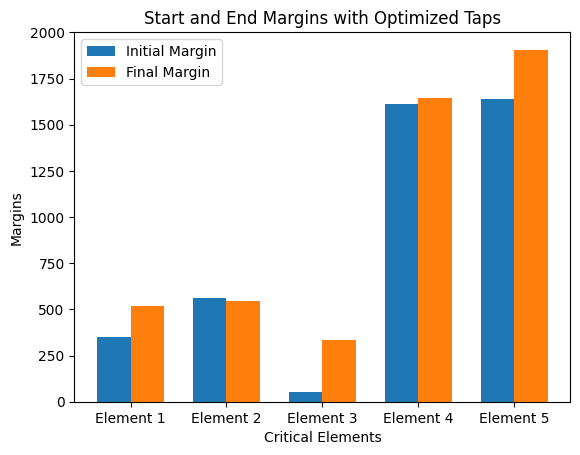

In [ ]:
import matplotlib.pyplot as plt

#-------------------------------------------------------------------------------
# Rounding optimized tap values
#-------------------------------------------------------------------------------
optimized_taps_rounded = [round(tap) for tap in optimized_taps]

#-------------------------------------------------------------------------------
# Defining indices and bar widths
#-------------------------------------------------------------------------------
index = np.arange(len(initial_margins))
bar_width = 0.35

#-------------------------------------------------------------------------------
# Labels for critical elements
#-------------------------------------------------------------------------------
elements = ['Element 1', 'Element 2', 'Element 3', 'Element 4', 'Element 5']

#-------------------------------------------------------------------------------
# Creating a bar chart
#-------------------------------------------------------------------------------
fig, ax = plt.subplots()
bar1 = ax.bar(index, initial_margins, bar_width, label='Initial Margin')
bar2 = ax.bar([i + bar_width for i in index], final_margins, bar_width,
              label='Final Margin')

#-------------------------------------------------------------------------------
# Chart configurations
#-------------------------------------------------------------------------------
ax.set_xlabel('Critical Elements')
ax.set_ylabel('Margins')
ax.set_title('Start and End Margins with Optimized Taps')
ax.set_xticks([i + bar_width / 2 for i in index])
ax.set_xticklabels(elements)
ax.legend()

#-------------------------------------------------------------------------------
# Show chart
#-------------------------------------------------------------------------------
plt.show()
